In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
import mplfinance as mpf

import talib as ta

In [14]:
def get_stock_data_yf(symbol, type=None):
    stock_data = yf.Ticker(symbol)
    history = stock_data.history(period="max").sort_index()
    if type is not None:
        history = history.resample(type).agg({"Open": "first", "High": "max", "Low": "min", "Close": "last", "Volume": "sum"})
    company_name = stock_data.info["longName"]
    return history, company_name


def golden_and_dead_cross(df):
    df["ma05>ma25"] = df["ma05"] > df["ma25"]
    temp_gc = (df["ma05>ma25"] != df["ma05>ma25"].shift(1)) & (df["ma05>ma25"] == True)
    temp_dc = (df["ma05>ma25"] != df["ma05>ma25"].shift(1)) & (df["ma05>ma25"] == False)
    df["gc"] = [m if g == True else None for m, g in zip(df["ma05"], temp_gc)]
    df["dc"] = [m if d == True else None for m, d in zip(df["ma25"], temp_dc)]
    return df.drop(columns=["ma05>ma25"])

## Get stock data


In [15]:
data, company_name = get_stock_data_yf("2181.T")  # ^GSPC
df = data.copy()
df["ma05"] = df["Close"].rolling(window=5).mean()
df["ma25"] = df["Close"].rolling(window=25).mean()
df = golden_and_dead_cross(df)
df["macd"], df["macd_signal"], df["hist"] = ta.MACD(df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)

print(f"\n  >   {company_name} ")

# -----------------------
# set start and end date
# -----------------------
start = (datetime.datetime.today() - pd.DateOffset(years=1)).strftime("%Y-%m-%d")
df = df[start:]

display(df.head(3), df.tail(3))


  >   Persol Holdings Co.,Ltd. 


,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma05,ma25,gc,dc,macd,macd_signal,hist
Date,,,,,,,,,,,,,,
2023-09-25 00:00:00+09:00,238.798830,243.423528,238.365252,242.941788,7809000,0.0,0.0,241.024460,243.473632,NaN,NaN,-2.295508,-2.323776,0.028268
2023-09-26 00:00:00+09:00,242.267356,242.652757,239.521443,240.195877,8681000,0.0,0.0,240.812497,243.537222,NaN,NaN,-2.317214,-2.322463,0.005249
2023-09-27 00:00:00+09:00,238.461607,241.063004,237.305433,241.063004,8302000,0.0,0.0,240.263312,243.550710,NaN,NaN,-2.238642,-2.305699,0.067057


,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma05,ma25,gc,dc,macd,macd_signal,hist
Date,,,,,,,,,,,,,,
2024-09-18 00:00:00+09:00,271.799988,275.000000,269.399994,273.100006,7565500,0.0,0.0,273.119995,278.587999,NaN,NaN,2.660316,5.185913,-2.525598
2024-09-19 00:00:00+09:00,276.899994,279.200012,275.799988,276.500000,4706800,0.0,0.0,273.639996,278.603999,NaN,NaN,2.487648,4.646260,-2.158612
2024-09-20 00:00:00+09:00,279.000000,280.399994,273.299988,274.899994,9780200,0.0,0.0,273.059998,278.719999,NaN,NaN,2.196382,4.156285,-1.959903


## Use Mplfinance

ref: [mplfinance](https://github.com/matplotlib/mplfinance)


Text(0.5, 1.0, 'Persol Holdings Co.,Ltd. (2023-09-23 ~ )')

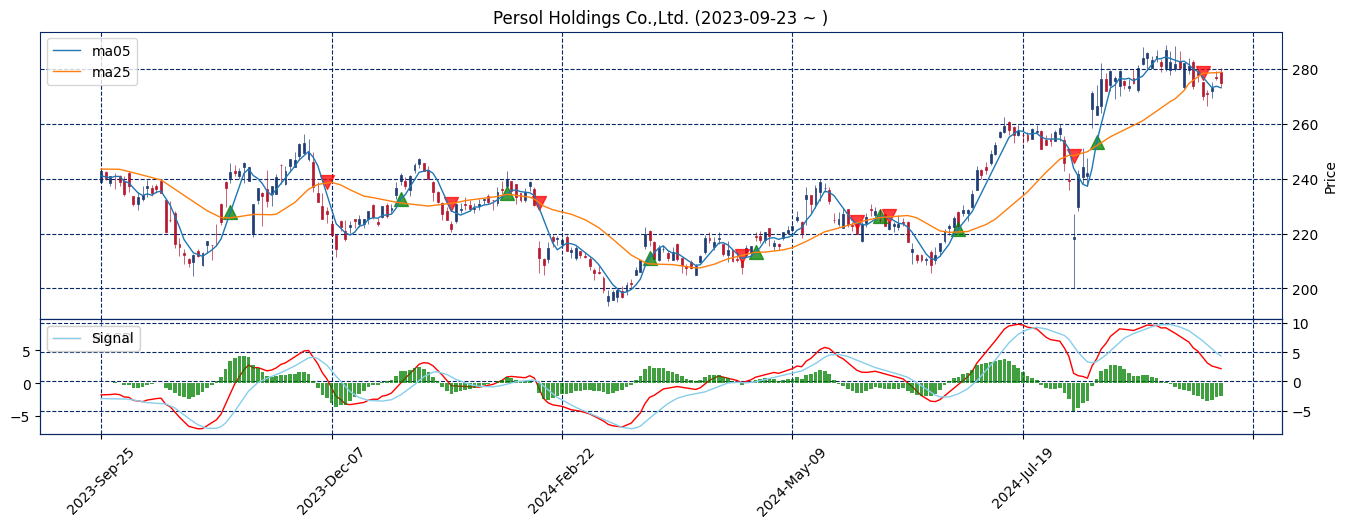

In [16]:
lines = [
    mpf.make_addplot(df["ma05"], panel=0, width=1),
    mpf.make_addplot(df["ma25"], panel=0, width=1),
    mpf.make_addplot(df["gc"], type="scatter", markersize=100, marker="^", color="g", panel=0, alpha=0.75),
    mpf.make_addplot(df["dc"], type="scatter", markersize=100, marker="v", color="r", panel=0, alpha=0.75),
    mpf.make_addplot(df["macd"], panel=1, width=1, color="red", label="MACD"),
    mpf.make_addplot(df["macd_signal"], panel=1, width=1, color="skyblue", label="Signal"),
    mpf.make_addplot(df["hist"], panel=1, type="bar", color="g", alpha=0.75),
]


fig, axes = mpf.plot(df, type="candle", figratio=(3, 1), addplot=lines, style="sas", returnfig=True)

axes[0].legend(axes[0].get_lines()[-2:], ["ma05", "ma25"], loc="best")
axes[2].legend(axes[2].get_lines()[-2:], ["MACD", "Signal"], loc="best")
axes[0].set_title(f"{company_name} ({start} ~ )")

## Use Plotly

ref: [plotly](https://plotly.com/python/time-series/)


In [17]:
import plotly.express as px
import pandas as pd

fig = px.line(df, x=df.index, y=["Close"], title=f"{company_name} Close Price")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list(
            [
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=12, label="12m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all"),
            ]
        )
    ),
)

fig.show()

# save png
with open("stock_chart1.png", "wb") as f:
    fig.write_image(f)

![stock_chart1](./stock_chart1.png)


In [18]:
fig = px.line(df, x=df.index, y=["Close", "ma05", "ma25"], title=f"{company_name} Close Price")
fig.add_scatter(x=df.index, y=df["gc"], mode="markers", name="Golden Cross", marker=dict(color="green", size=15, opacity=0.8), marker_symbol="triangle-up")
fig.add_scatter(x=df.index, y=df["dc"], mode="markers", name="Dead Cross", marker=dict(color="red", size=15, opacity=0.8), marker_symbol="triangle-down")

# --------------------------------
fig.update_layout(
    xaxis=dict(range=[df.index[0], df.index[-1]]),
    autosize=True,
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list(
            [
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=12, label="12m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all"),
            ]
        )
    ),
)

fig.show()

# save png
with open("stock_chart2.png", "wb") as f:
    fig.write_image(f)

![stock_chart2](./stock_chart2.png)
